In [1]:
from datasets import load_dataset

dataset_train = load_dataset("Falah/Alzheimer_MRI", split='train')
dataset_test = load_dataset("Falah/Alzheimer_MRI", split='test')

In [3]:
from transformers import AutoImageProcessor

checkpoint = "apple/mobilevit-small"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [4]:
def transform(example_batch):
    inputs = image_processor([x.convert('RGB') for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['label']
    return inputs

transformed_dataset_train = dataset_train.with_transform(transform)
transformed_dataset_test = dataset_test.with_transform(transform)

In [5]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [6]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(checkpoint,
                                                        num_labels=len(dataset_train.features["label"].names),
                                                        ignore_mismatched_sizes=True
                                                       )

training_args = TrainingArguments(
    output_dir="model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=10,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=transformed_dataset_train,
    eval_dataset=transformed_dataset_test,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([4, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.339000,1.397448,0.347656
2,1.247400,1.261046,0.561719
3,1.162400,1.134973,0.581250
4,1.093300,1.102157,0.586719
5,1.050200,1.063965,0.598437
6,1.001600,1.035893,0.610156
7,0.986900,1.025785,0.619531
8,0.954500,0.989861,0.631250
9,0.946900,0.986397,0.632031
10,0.944300,0.980222,0.631250


TrainOutput(global_step=200, training_loss=1.0832837009429932, metrics={'train_runtime': 343.5975, 'train_samples_per_second': 149.012, 'train_steps_per_second': 0.582, 'total_flos': 2.983778473476096e+17, 'train_loss': 1.0832837009429932, 'epoch': 10.0})

In [43]:
metrics = trainer.evaluate(transformed_dataset_test)
outputs = trainer.predict(transformed_dataset_test)
print(metrics)

{'eval_loss': 0.9863974452018738, 'eval_accuracy': 0.63203125, 'eval_runtime': 4.4379, 'eval_samples_per_second': 288.425, 'eval_steps_per_second': 1.127, 'epoch': 10.0}


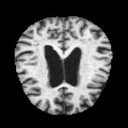

In [36]:
dataset_test[0]['image']

In [51]:
outputs.predictions[0]

array([-0.47102004, -0.32282358,  1.4218521 , -0.8353001 ], dtype=float32)

In [53]:
outputs.predictions[0].argmax(-1)

2